# 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# 1. 데이터 로드

In [2]:
df = pd.read_excel('화재 위험도 계산 데이터/최종본.xlsx')
df.head()

,year,month,day,ws,ta,hm,rn,result,pa,ps,td,ss,si,ts
0,2019,1,1,3.0,4.1,36,0.0,0,1019.9,1028.6,-9.6,1.0,2.08,17.1
1,2019,1,2,3.9,4.2,30,0.0,1,1021.5,1030.2,-11.8,1.0,2.12,17.8
2,2019,1,3,5.1,5.3,20,0.0,1,1023.5,1032.2,-15.9,1.0,2.14,17.8
3,2019,1,4,5.8,6.3,20,0.0,0,1019.7,1028.4,-15.0,0.1,0.83,9.8
4,2019,1,5,4.4,7.0,40,0.0,1,1015.3,1023.3,-5.7,0.3,0.79,15.4


In [3]:
result_counts = df['result'].value_counts(normalize=True) * 100  # 비율(%)
print("result 0과 1의 비율:")
print(result_counts)

result 0과 1의 비율:
result
0    72.109589
1    27.890411
Name: proportion, dtype: float64


# 2. 데이터 분석

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

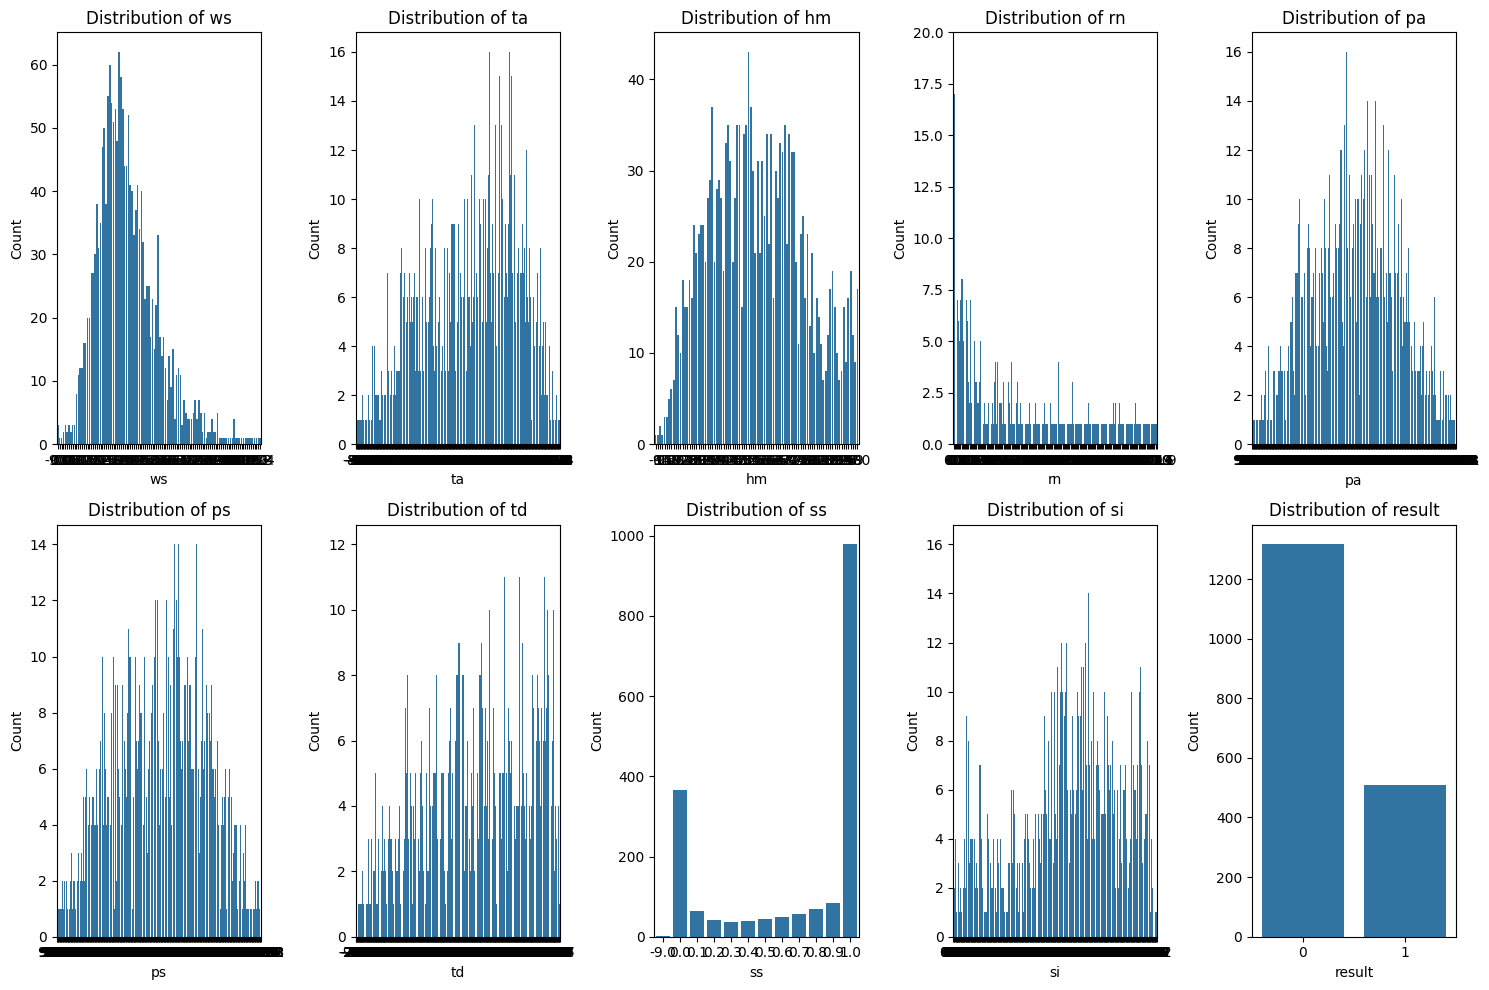

In [5]:
# 변수 리스트
columns_to_plot = ['ws', 'ta', 'hm', 'rn', 'pa', 'ps', 'td', 'ss', 'si', 'result']
# 바플롯 시각화
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 5, i + 1)
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # rn의 y축 범위 조정
    if column == 'rn':
        plt.ylim(0, 20)  # y축 범위를 0에서 5로 설정

plt.tight_layout()
plt.show()

# 3. 데이터 전처리

In [6]:
# X, y 분리
X = df[['year', 'month', 'day', 'ws', 'ta', 'hm', 'rn', 'pa', 'ps', 'td', 'ss', 'si']]  # 특징
y = df['result']  # 레이블

In [7]:
# 훈련 세트와 테스트 세트로 9:1 비율로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['ws', 'ta', 'hm', 'rn', 'pa', 'ps', 'td', 'ss', 'si']),  # 연속형 변수 표준화
        ('cat', OneHotEncoder(), ['year', 'month', 'day'])     # 원-핫 인코딩
    ]
)

In [9]:
# 모델 파이프라인
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=42))])

# 4. 모델학습

In [10]:
# 모델 학습
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['ws', 'ta', 'hm', 'rn', 'pa',
                                                   'ps', 'td', 'ss', 'si']),
                                                 ('cat', OneHotEncoder(),
                                                  ['year', 'month', 'day'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

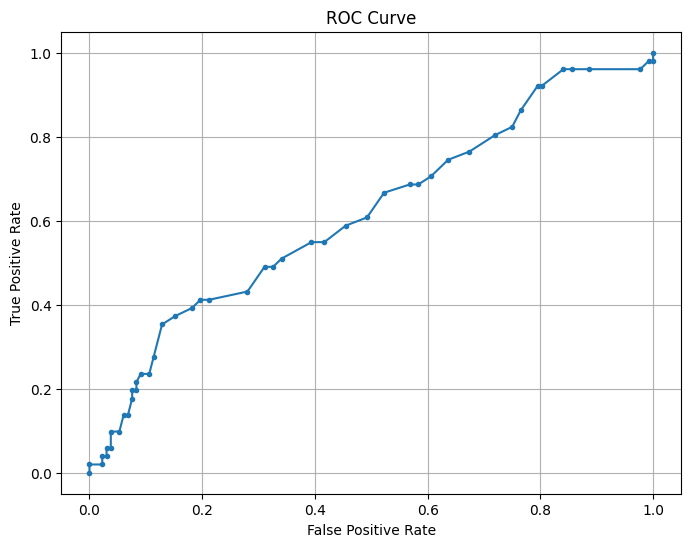

Optimal Threshold: 0.38


In [11]:
# 예측 확률
y_scores = model.predict_proba(X_test)[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

# 최적의 threshold 찾기 (TPR와 FPR의 차이가 가장 큰 지점)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# 5. 예측 및 평가

In [12]:
# 최적의 threshold를 사용하여 예측
y_val_pred = (y_scores >= optimal_threshold).astype(int)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, y_val_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, y_scores))
print("검증 세트 보고서:\n", classification_report(y_test, y_val_pred))

검증 세트 정확도: 0.726775956284153
검증 세트 ROC AUC 점수: 0.6166072489601901
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       132
           1       0.51      0.35      0.42        51

    accuracy                           0.73       183
   macro avg       0.65      0.61      0.62       183
weighted avg       0.70      0.73      0.71       183



In [13]:
y_val_pred = model.predict(X_test)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, y_val_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("검증 세트 보고서:\n", classification_report(y_test, y_val_pred))

검증 세트 정확도: 0.7103825136612022
검증 세트 ROC AUC 점수: 0.6166072489601901
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.73      0.95      0.83       132
           1       0.42      0.10      0.16        51

    accuracy                           0.71       183
   macro avg       0.57      0.52      0.49       183
weighted avg       0.64      0.71      0.64       183



In [15]:
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # 양성 클래스에 대한 확률

# 7. 테스트 세트와 예측 결과 출력
test_results = pd.DataFrame({
    '정답': y_test,
    '예측': y_test_pred,
    '예측 확률': y_test_pred_proba,
    # '날짜': pd.to_datetime(X_test[['year', 'month', 'day']]).dt.strftime('%Y-%m-%d'),
    '풍속 (ws)': X_test['ws'].values,
    '기온 (ta)': X_test['ta'].values,
    '습도 (hm)': X_test['hm'].values,
    '일일강수량 (rn)': X_test['rn'].values
})

In [21]:
print("\n테스트 세트 결과:")
test_results.sample(15)


테스트 세트 결과:


,정답,예측,예측 확률,풍속 (ws),기온 (ta),습도 (hm),일일강수량 (rn)
1541,0,0,0.33,3.4,16.5,96,56.0
575,1,1,0.52,0.6,25.5,93,51.3
518,0,0,0.31,3.6,24.2,41,0.0
27,0,0,0.10,5.4,9.5,36,0.0
752,1,0,0.21,1.3,11.5,98,2.9
271,0,0,0.17,3.0,27.2,80,0.0
1448,0,1,0.64,1.7,6.2,38,0.0
161,0,0,0.16,3.0,19.4,70,0.0
1282,1,0,0.45,7.9,35.3,56,0.0
1515,0,0,0.14,3.4,9.1,29,0.0


In [ ]:
# 특성 중요도 가져오기
importances = model.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()